In [4]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [5]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# Ensure TF does not see GPU and grab all GPU memory.
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from model import add_model_args, get_model
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Argumentsget_data_args

In [15]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"
args.feature_scaler = "standard"

args.smoke_test = False
args.wandb_mode = "disabled"
args.wandb_resume = True
args.id = None # "2uuq7tks"
args.batch_size = 2048
args.n_epochs = 10
args.model = "lr"

### Logger


In [16]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

### Load Data

In [17]:
%%time

# load data
data = load_data(args)

# preprocess data
data = preprocess_data(data, args)

# feature transformation
data, scaler = feature_transform(data, args)

# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

100%|██████████| 6/6 [00:00<00:00, 61.19it/s]


CPU times: user 2.74 s, sys: 256 ms, total: 3 s
Wall time: 3 s


In [19]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,-1.999917e-12,-8.776303e-13,3.685513e-10
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.949781e+00,-1.638213e+00,-1.671579e+00
25%,-8.239073e-01,-8.429874e-01,-9.186683e-01
50%,5.915465e-02,-5.483249e-02,5.081266e-02
75%,8.765120e-01,7.516934e-01,8.303645e-01
max,1.597494e+00,2.196721e+00,1.772641e+00


### Model

In [20]:
# %%time


# # model
# model = get_model(args)

# # optimizer
# optimizer = get_optimizer(args)

# # loss
# make_step, val_step = get_loss_fn(args)

# # init model
# opt_state = optimizer.init(model)

In [21]:
# n_steps_per_epoch = args.n_train / args.batch_size
# steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


# wandb.config.update(
#     {
#         "steps": steps,
#         "n_steps_per_epoch": n_steps_per_epoch,
#     }
# )

In [22]:
from sklearn.linear_model import LinearRegression

### Training

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Linear Regression

In [24]:
%%time

model = LinearRegression()

# fit model
model.fit(xtrain, ytrain)

# predict model
preds = model.predict(xvalid)

# mae = 

CPU times: user 116 ms, sys: 52 ms, total: 168 ms
Wall time: 209 ms


### Save models

In [26]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(model, path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

### Load Models (Optional)

In [27]:
# # if args.server == "jz":
# # get id (from this run or a run you can set)
# run_id = wandb.run.id

# # initialize api
# api = wandb.Api()

# # get run
# run = api.run(f"{args.entity}/{args.project}/{run_id}")

# # download the files
# files = ["scaler.pickle", "model.pickle"]

# for ifile in files:
    
#     run.file(ifile).download(replace=True)

In [28]:
# model = load_object("./model.pickle")
# scaler = load_object("./scaler.pickle")

### PostProcessing

In [29]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,967980.000000,967980.000000,967980.000000
mean,300.000000,38.100000,213.000000
std,2.943922,3.001668,105.366083
min,295.000000,33.000000,31.000000
25%,297.400000,35.550000,122.000000
50%,300.000000,38.100000,213.000000
75%,302.600000,40.650000,304.000000
max,305.000000,43.200000,395.000000


In [43]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

['longitude', 'latitude', 'time']


,longitude,latitude,time,vtime,pred
count,967980.000000,967980.000000,967980.000000,967980.000000,967980.000000
mean,-0.176144,0.292042,0.050524,213.000000,0.096517
std,0.348097,0.383708,0.852070,105.366083,0.021474
min,-0.767357,-0.359899,-1.421267,31.000000,0.050180
25%,-0.483575,-0.033928,-0.685372,122.000000,0.078396
50%,-0.176144,0.292042,0.050524,213.000000,0.096517
75%,0.131287,0.618013,0.786419,304.000000,0.114637
max,0.415069,0.943984,1.522314,395.000000,0.142853


In [31]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

### Predictions


In [18]:
# @jax.jit
# def pred_step(model, data):
#     return jax.vmap(model)(data)

In [32]:
df_pred = df_pred[df_pred.attrs["input_cols"]]

In [33]:

import time

t0 = time.time()
df_grid["pred"] = model.predict(df_pred)
t1 = time.time() - t0

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [34]:
from functools import partial
import time

In [35]:
wandb.config.update(
    {
        "time_predict_batches": t1,
    }
)

In [36]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/si

In [37]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 365)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 967977 967978 967979
    vtime      (latitude, longitude, time) float64 31.0 32.0 ... 394.0 395.0
    pred       (latitude, longitude, time) float64 0.07057 0.07077 ... 0.1225
    ssh        (latitude, longitude, time) float64 0.6702 0.6704 ... -0.05388

In [38]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)
print(rmse_metrics)

RMSE (Mean): 0.266
RMSE (Std): 0.078
NRMSE (Mean): 0.564
NRMSE (Std): 0.174
CPU times: user 436 ms, sys: 32 ms, total: 468 ms
Wall time: 630 ms


In [39]:
psd_metrics = get_psd_metrics(ds_oi, args)

In [40]:
print(psd_metrics)

Resolved Scale: 572909062560892.375 (km)


### Figures

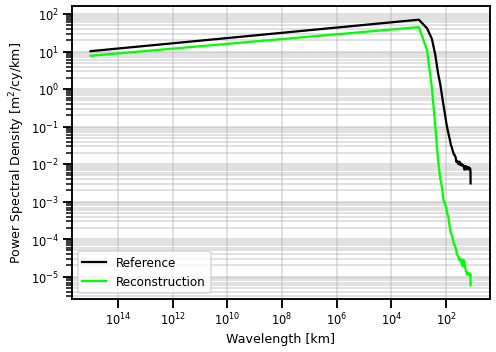

In [41]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

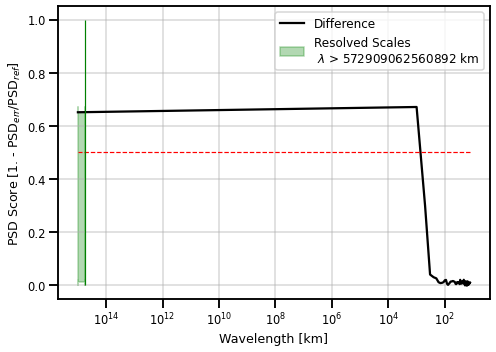

In [42]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [31]:
save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [1]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [33]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [34]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

In [35]:
f"{save_path}/movie_pred.gif"

'/tmp/movie_pred.gif'

![](/tmp/movie_pred.gif)

### Gradients

In [36]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [37]:
ds_oi.ssh_grad.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="Spectral_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_grad)

In [38]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [39]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [40]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [41]:
ds_oi.ssh_lap.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_lap)

In [42]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [43]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )